## CMPE 258 - HW 5

## Abhishek Bais

## This notebook is a modified version of [noteebook](https://github.com/offirinbar/NYC_Taxi/blob/master/NYC_Taxi_PyTorch.ipynb) authored by Offir Inbar.

## 1. NYC Taxi Fare Prediction dataset is no available via Kaggle API so this collab has been modified to work for Chicago Taxi dataset instead.

## 2. In Part A, Part B the author also loads Chicago Taxi dataset, probably for the same reason, although he says in title of colab that it is NYC Taxi Fare prediction dataset.

## 0.0 Abhishek Added - Search for NYC Taxi Fare prediction dataset on Kaggle

In [1]:
!pip install kaggle

In [17]:
!cp /content/.kaggle/kaggle.json /root/.kaggle/kaggle.json

In [18]:
ls /root/.kaggle/

kaggle.json


In [19]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [20]:
!chmod 600 /root/.kaggle/kaggle.json

## 0.1 Abhishek Added - Kaggle says dataset available via Kaggle API here 
kaggle competitions download -c new-york-city-taxi-fare-prediction

In [23]:
!kaggle datasets list -s new-york-city

ref                                                   title                                          size  lastUpdated          downloadCount  
----------------------------------------------------  --------------------------------------------  -----  -------------------  -------------  
dgomonov/new-york-city-airbnb-open-data               New York City Airbnb Open Data                  2MB  2019-08-12 16:24:45          97352  
fivethirtyeight/uber-pickups-in-new-york-city         Uber Pickups in New York City                 109MB  2019-11-13 19:52:18          30178  
adamschroeder/crimes-new-york-city                    New York City Crimes                           50MB  2017-08-11 04:54:29           4281  
new-york-city/nyc-property-sales                      NYC Property Sales                              2MB  2017-09-22 19:43:30          16153  
muonneutrino/new-york-city-census-data                New York City Census Data                     343KB  2017-08-04 06:17:42          

## 0.2: Abhishek Added - 
### debanjanpaul/new-york-city-taxi-trip-distance-matrix dataset is the only NYC taxi dataset available. Its about taxi trip distance

In [26]:
!kaggle datasets list -s new-york-city-taxi-fare

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python2.7/dist-packages/kaggle/cli.py", line 51, in main
    out = args.func(**command_args)
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 910, in dataset_list_cli
    tag_ids, search, user, mine, page)
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 880, in dataset_list
    return [Dataset(d) for d in datasets_list_result]
  File "/usr/local/lib/python2.7/dist-packages/kaggle/models/kaggle_models_extended.py", line 66, in __init__
    self.size = File.get_size(self.totalBytes)
  File "/usr/local/lib/python2.7/dist-packages/kaggle/models/kaggle_models_extended.py", line 97, in get_size
    return '%.*f%s' % (precision, size, suffixes[suffix_index])
TypeError: float argument required, not NoneType


In [27]:
!kaggle datasets list -s new-york-city-taxi-fare-prediction

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python2.7/dist-packages/kaggle/cli.py", line 51, in main
    out = args.func(**command_args)
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 910, in dataset_list_cli
    tag_ids, search, user, mine, page)
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 880, in dataset_list
    return [Dataset(d) for d in datasets_list_result]
  File "/usr/local/lib/python2.7/dist-packages/kaggle/models/kaggle_models_extended.py", line 66, in __init__
    self.size = File.get_size(self.totalBytes)
  File "/usr/local/lib/python2.7/dist-packages/kaggle/models/kaggle_models_extended.py", line 97, in get_size
    return '%.*f%s' % (precision, size, suffixes[suffix_index])
TypeError: float argument required, not NoneType


## 0.3. Will proceed with Chicago taxi fare dataset

# Import libraries


In [ ]:
## import libraries

#PyTorch 

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as torch_optim
from torchvision import models
from torch.nn import init
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils import data
from torch.optim import lr_scheduler

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing


#other
from IPython.core.debugger import set_trace
import pandas as pd
import numpy as np
from collections import Counter
from datetime import datetime
import math 
from google.colab import files
import io
import datetime as dt
import re
import pandas_profiling
import pandas_profiling as pp
from math import sqrt

#graphs
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import pylab as plt
import matplotlib.dates as dates
import seaborn as sns
import pylab
import matplotlib
import matplotlib.dates
from IPython.display import display
import plotly.graph_objects as go


%matplotlib inline

In [ ]:
# load tqdm
#!pip install --force https://github.com/chengs/tqdm/archive/colab.zip
from tqdm import tqdm, tqdm_notebook, tnrange

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Help Functions

In [ ]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

# Data injestion

## 1.0. Abhishek Added -  Upload Data for Chicago Taxi

In [ ]:
!wget https://raw.githubusercontent.com/tensorflow/tfx/master/tfx/examples/chicago_taxi_pipeline/data/simple/data.csv

--2021-04-18 16:38:30--  https://raw.githubusercontent.com/tensorflow/tfx/master/tfx/examples/chicago_taxi_pipeline/data/simple/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1922812 (1.8M) [text/plain]
Saving to: ‘data.csv.1’

data.csv.1          100%[===================>]   1.83M  --.-KB/s    in 0.06s   

2021-04-18 16:38:30 (30.2 MB/s) - ‘data.csv.1’ saved [1922812/1922812]



## 2.0. Abhishek Added - Data injestion

In [ ]:
df = pd.read_csv('/content/data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15002 entries, 0 to 15001
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   pickup_community_area   15000 non-null  float64
 1   fare                    15002 non-null  float64
 2   trip_start_month        15002 non-null  int64  
 3   trip_start_hour         15002 non-null  int64  
 4   trip_start_day          15002 non-null  int64  
 5   trip_start_timestamp    15002 non-null  int64  
 6   pickup_latitude         15000 non-null  float64
 7   pickup_longitude        15000 non-null  float64
 8   dropoff_latitude        14519 non-null  float64
 9   dropoff_longitude       14519 non-null  float64
 10  trip_miles              15002 non-null  float64
 11  pickup_census_tract     1 non-null      float64
 12  dropoff_census_tract    10761 non-null  float64
 13  payment_type            15002 non-null  object 
 14  company                 9862 non-null 

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15002 entries, 0 to 15001
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   pickup_community_area   15000 non-null  float64
 1   fare                    15002 non-null  float64
 2   trip_start_month        15002 non-null  int64  
 3   trip_start_hour         15002 non-null  int64  
 4   trip_start_day          15002 non-null  int64  
 5   trip_start_timestamp    15002 non-null  int64  
 6   pickup_latitude         15000 non-null  float64
 7   pickup_longitude        15000 non-null  float64
 8   dropoff_latitude        14519 non-null  float64
 9   dropoff_longitude       14519 non-null  float64
 10  trip_miles              15002 non-null  float64
 11  pickup_census_tract     1 non-null      float64
 12  dropoff_census_tract    10761 non-null  float64
 13  payment_type            15002 non-null  object 
 14  company                 9862 non-null 

## 3.0. Abhishek Added - Data preprocessing, drop useless columns

In [ ]:
##Drop useless columns
df = df.drop(['trip_start_timestamp','trip_miles','pickup_census_tract',
              'dropoff_census_tract','trip_seconds','payment_type','tips', 
              'company','dropoff_community_area','pickup_community_area'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15002 entries, 0 to 15001
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fare               15002 non-null  float64
 1   trip_start_month   15002 non-null  int64  
 2   trip_start_hour    15002 non-null  int64  
 3   trip_start_day     15002 non-null  int64  
 4   pickup_latitude    15000 non-null  float64
 5   pickup_longitude   15000 non-null  float64
 6   dropoff_latitude   14519 non-null  float64
 7   dropoff_longitude  14519 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 937.8 KB


## 4.0. Abhishek Added - Data preprocessing, drop fares > $200

In [ ]:
#Drop NA rows
df = df.dropna()

#Drop rows where FARE > 200( only 1 row found )
df = df.drop(df[df['fare'] > 200].index)

#Change datatype of cols
df['trip_start_month'] = df['trip_start_month'].astype('str')
df['trip_start_hour'] = df['trip_start_hour'].astype('str')
df['trip_start_day'] = df['trip_start_day'].astype('str')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14518 entries, 28 to 15000
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fare               14518 non-null  float64
 1   trip_start_month   14518 non-null  object 
 2   trip_start_hour    14518 non-null  object 
 3   trip_start_day     14518 non-null  object 
 4   pickup_latitude    14518 non-null  float64
 5   pickup_longitude   14518 non-null  float64
 6   dropoff_latitude   14518 non-null  float64
 7   dropoff_longitude  14518 non-null  float64
dtypes: float64(5), object(3)
memory usage: 1020.8+ KB


## 5.0. Abhishek Added - Train/Test split

In [ ]:
##Train test split ( Original DF )
np.random.seed(seed=2)
msk = np.random.rand(len(df)) < 0.85
df_train = df[msk]
df_test = df[~msk]

print(len(df_train))
print(len(df_test))

df_train.to_csv("train.csv", index=False, header=False)
df_test.to_csv("eval.csv", index=False, header=False)

12347
2171


In [ ]:
df_train.head()

,fare,trip_start_month,trip_start_hour,trip_start_day,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
28,12.25,10,1,1,41.952823,-87.653244,41.920452,-87.679955
29,3.85,3,15,6,41.899670,-87.669838,41.920452,-87.679955
30,6.05,8,23,5,41.906026,-87.675312,41.920452,-87.679955
31,7.25,10,21,7,41.906651,-87.665338,41.920452,-87.679955
32,7.85,11,11,2,41.871016,-87.631407,41.849247,-87.624135


In [ ]:
df_test.head()

,fare,trip_start_month,trip_start_hour,trip_start_day,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
44,5.85,10,0,7,42.001571,-87.695013,42.001571,-87.695013
68,9.05,2,21,2,41.928619,-87.685362,41.957736,-87.683718
70,5.65,1,19,1,41.929047,-87.651311,41.921877,-87.664078
77,9.65,4,1,2,41.906026,-87.675312,41.892042,-87.631864
81,8.45,7,20,7,41.906026,-87.675312,41.892042,-87.631864


## 6.0. Abhishek Added - Data inspection, percent fares > $0

In [ ]:
# Inspect fares > 0
df_train = df_train.loc[df_train.fare > 0]
df_train.fare.min()

0.01

In [ ]:
len(df_train)

12334

In [ ]:
train_X = df_train.drop(columns=['fare'])
Y = np.log(df_train.fare)
test_X = df_test

In [ ]:
df = train_X.append(test_X,sort=False)

##Calculate the distance traveled

In [ ]:
df['dist_km'] = haversine_distance(df,'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')
df.head()

,trip_start_month,trip_start_hour,trip_start_day,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,fare,dist_km
28,10,1,1,41.952823,-87.653244,41.920452,-87.679955,NaN,4.223525
29,3,15,6,41.899670,-87.669838,41.920452,-87.679955,NaN,2.457759
30,8,23,5,41.906026,-87.675312,41.920452,-87.679955,NaN,1.649418
31,10,21,7,41.906651,-87.665338,41.920452,-87.679955,NaN,1.953926
32,11,11,2,41.871016,-87.631407,41.849247,-87.624135,NaN,2.494392


# Prepare the model

## define Categorical and continuous columns

In [ ]:
df.columns

Index(['trip_start_month', 'trip_start_hour', 'trip_start_day',
       'pickup_latitude', 'pickup_longitude', 'dropoff_latitude',
       'dropoff_longitude', 'fare', 'dist_km'],
      dtype='object')

In [ ]:
cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']


In [ ]:
df.head()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,dist_km
28,1.371758,0.021716,0.460702,-0.460363,-0.065772
29,-0.076023,-0.241693,0.460702,-0.460363,-0.344658
30,0.097097,-0.328584,0.460702,-0.460363,-0.472328
31,0.114115,-0.170258,0.460702,-0.460363,-0.424234
32,-0.856512,0.368363,-1.382635,0.529041,-0.338872


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14505 entries, 28 to 14990
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pickup_latitude    14505 non-null  float64
 1   pickup_longitude   14505 non-null  float64
 2   dropoff_latitude   14505 non-null  float64
 3   dropoff_longitude  14505 non-null  float64
 4   dist_km            14505 non-null  float64
dtypes: float64(5)
memory usage: 679.9 KB


##Take the relevent columns for the Model and Split back to train and test

In [ ]:
df.columns

Index(['pickup_latitude', 'pickup_longitude', 'dropoff_latitude',
       'dropoff_longitude', 'dist_km'],
      dtype='object')

## 7.0. Abhishek Added - Keep the relevant columns for the analysis

In [ ]:
# keep only the cols for the model
df = df[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'dist_km']]

## 8.0. Abhishek Edited - Prepare the df_train, df_test

In [ ]:
df_train = df[:12334]
df_test = df[12334:]

##Continuous values

In [ ]:
#Normalizing 

from pandas.api.types import is_numeric_dtype

#"Compute the means and stds of `self.cont_names` columns to normalize them."
def Normalize(df):
  means,stds = {},{}
  cont_names = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'dist_km']
  for n in cont_names:
    assert is_numeric_dtype(df[n]), (f"""Cannot normalize '{n}' column as it isn't numerical. Are you sure it doesn't belong in the categorical set of columns?""")
    means[n],stds[n] = df[n].mean(),df[n].std()
    df[n] = (df[n]-means[n]) / (1e-7 + stds[n])


Normalize(df_train)
Normalize(df_test)
X = df_train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_train.head()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,dist_km
28,1.371761,0.021716,0.460703,-0.460364,-0.065772
29,-0.076023,-0.241693,0.460703,-0.460364,-0.344658
30,0.097097,-0.328585,0.460703,-0.460364,-0.472328
31,0.114115,-0.170258,0.460703,-0.460364,-0.424234
32,-0.856514,0.368364,-1.382639,0.529042,-0.338872


In [ ]:
X.shape

(12334, 5)

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12334 entries, 28 to 15000
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pickup_latitude    12334 non-null  float64
 1   pickup_longitude   12334 non-null  float64
 2   dropoff_latitude   12334 non-null  float64
 3   dropoff_longitude  12334 non-null  float64
 4   dist_km            12334 non-null  float64
dtypes: float64(5)
memory usage: 578.2 KB


In [ ]:
Y.shape

(12334,)

## train-valid split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.20, random_state=142,shuffle=True ) 
X_train.head()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,dist_km
9032,-0.314307,0.567394,-0.560757,0.376408,-0.481199
10785,-0.584716,0.347093,-0.111930,0.588818,-0.390413
7718,-0.077877,0.338179,1.168480,-0.529140,0.340544
1292,-0.642703,0.467011,-0.079044,0.366454,-0.353516
1337,-0.642703,0.467011,-0.741690,-0.169012,-0.224457


#Model

##Tabular Model

## 9.0. Abhishek Updated - To create a model compatible for Chicago Taxi
Chicago Taxi does not have pickup_datetime that NYC has and were used to create categorical columns such as these for the NYC taxi.  
df['EDTdate']  
df['Hour']   
df['AMorPM']   
df['Weekday']   

## This model has only continous columns

In [ ]:
# help functions

from collections.abc import Iterable


def bn_drop_lin(n_in:int, n_out:int, bn:bool=True, p:float=0., actn=None):
    "Sequence of batchnorm (if `bn`), dropout (with `p`) and linear (`n_in`,`n_out`) layers followed by `actn`."
    layers = [nn.BatchNorm1d(n_in)] if bn else []
    if p != 0: layers.append(nn.Dropout(p))
    layers.append(nn.Linear(n_in, n_out))
    if actn is not None: layers.append(actn)
    return layers

def ifnone(a,b):
    "`a` if `a` is not None, otherwise `b`."
    return b if a is None else a

def listify(p, q):
    "Make `p` listy and the same length as `q`."
    if p is None: p=[]
    elif isinstance(p, str):          p = [p]
    elif not isinstance(p, Iterable): p = [p]
    #Rank 0 tensors in PyTorch are Iterable but don't have a length.
    else:
        try: a = len(p)
        except: p = [p]
    n = q if type(q)==int else len(p) if q is None else len(q)
    if len(p)==1: p = p * n
    assert len(p)==n, f'List len mismatch ({len(p)} vs {n})'
    return list(p)

              

class TabularModel(nn.Module):
    "Basic model for tabular data."
    def __init__(self, n_cont:int, out_sz:int, layers, ps=None,
                 y_range=None, use_bn:bool=True, bn_final:bool=False):
        super().__init__()
        ps = ifnone(ps, [0]*len(layers))
        ps = listify(ps, layers)
                   
        self.bn_cont = nn.BatchNorm1d(n_cont) #type torch.nn.modules.batchnorm.BatchNorm1d       
        self.n_cont,self.y_range = n_cont,y_range
        sizes = [n_cont] + layers + [out_sz] #typeL list, len: 4
        actns = [nn.ReLU(inplace=True) for _ in range(len(sizes)-2)] + [None] #type: list, len: 3.  the last in None because we finish with linear
        layers = []
        for i,(n_in,n_out,dp,act) in enumerate(zip(sizes[:-1],sizes[1:],[0.]+ps,actns)):
            layers += bn_drop_lin(n_in, n_out, bn=use_bn and i!=0, p=dp, actn=act)
        if bn_final: layers.append(nn.BatchNorm1d(sizes[-1]))
        self.layers = nn.Sequential(*layers) #type: torch.nn.modules.container.Sequential
        

    def forward(self, x_cont):
        if self.n_cont != 0:
            x_cont = self.bn_cont(x_cont) # batchnorm1d
            x = x_cont 
        x = self.layers(x)
        if self.y_range is not None:
            x = (self.y_range[1]-self.y_range[0]) * torch.sigmoid(x) + self.y_range[0] # deal with y_range
        return x.squeeze()
    

In [ ]:
torch.manual_seed(33)

In [ ]:
y_range = (0, y_train.max()*1.2)
y_range

(0, 5.669142800253904)

In [ ]:
cont_cols_1 = ['pickup_latitude',
              'pickup_longitude',
              'dropoff_latitude',
              'dropoff_longitude',
              'dist_km']

In [ ]:
model = TabularModel(n_cont = len(cont_cols_1),out_sz = 1,layers = [1000,500,250],ps= [0.001,0.01,0.01],y_range=y_range).to(device)
model

TabularModel(
  (bn_cont): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=5, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.001, inplace=False)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.01, inplace=False)
    (8): Linear(in_features=500, out_features=250, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.01, inplace=False)
    (12): Linear(in_features=250, out_features=1, bias=True)
  )
)

## optimizer

## 10.0. Abhishek Added - Hyper param tuning
lr = 1e-10

In [ ]:
from collections import defaultdict
opt = torch.optim.Adam(model.parameters(), lr=1e-10) # can add: weight_decay=
#lr_cosine = lr_scheduler.CosineAnnealingLR(opt,T_max = 350) #1000 ## if you want to add lr_cosine



lr = defaultdict(list)
tloss = defaultdict(list)
vloss = defaultdict(list)

##Train and Fit

## 11.0. Abhishek edited the fit API to work on Chicago Taxi which doesnt have categorical columns

In [ ]:
def inv_y(y): return np.exp(y)

def rmse(targ, y_pred):
    return np.sqrt(mean_squared_error(inv_y(y_pred), inv_y(targ))) #.detach().numpy()
    

def rmse(targ, y_pred):
   return np.sqrt(mean_squared_error(y_pred, targ)) #.detach().numpy()


#def fit(model, train_dl, val_dl, loss_fn, opt, scheduler, epochs=3): ## if you want to add schedular
def fit(model, train_dl, val_dl, loss_fn, opt, epochs=3):
    num_batch = len(train_dl)
    for epoch in tnrange(epochs):      
        y_true_train = list()
        y_pred_train = list()
        total_loss_train = 0          
        
        t = tqdm_notebook(iter(train_dl), leave=False, total=num_batch)
        for cont, y in t:
            cont = cont.cuda()
            y = y.cuda()
            t.set_description(f'Epoch {epoch}')
            
            opt.zero_grad() #find where the grads are zero
            pred = model(cont)
            loss = loss_fn(pred, y)
            
            loss.backward() # do backprop
            lr[epoch].append(opt.param_groups[0]['lr'])
            tloss[epoch].append(loss.item())
            opt.step()
            #scheduler.step()
            
            
            t.set_postfix(loss=loss.item())
            
            y_true_train += list(y.cpu().data.numpy())
            y_pred_train += list(pred.cpu().data.numpy())
            total_loss_train += loss.item()
            
        train_acc = rmse(y_true_train, y_pred_train)
        train_loss = total_loss_train/len(train_dl) # len train_dl = 704. the calc is number of train examples (89991) / batch size (128)
        
        if val_dl:
            y_true_val = list()
            y_pred_val = list()
            total_loss_val = 0
            for cont, y in tqdm_notebook(val_dl, leave=False):
                cont = cont.cuda()
                y = y.cuda()
                pred = model(cont)
                loss = loss_fn(pred, y)
                
                y_true_val += list(y.cpu().data.numpy())
                y_pred_val += list(pred.cpu().data.numpy())
                total_loss_val += loss.item()
                vloss[epoch].append(loss.item())
            valacc = rmse(y_true_val, y_pred_val)
            valloss = total_loss_val/len(valdl)
            print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_rmse: {train_acc:.4f} | val_loss: {valloss:.4f} val_rmse: {valacc:.4f}')
        else:
            print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_rmse: {train_acc:.4f}')
    
    return lr, tloss, vloss

## 12.0. Abhishek Edited - Pytorch dataloaders

In [ ]:
class RegressionColumnarDataset(data.Dataset):
    def __init__(self, df, cats, y):   
        self.dfconts = df[cats] #type: pandas.core.frame.DataFrame  
        self.conts = np.stack([c.values for n, c in self.dfconts.items()], axis=1).astype(np.float32) #tpye: numpy.ndarray
        self.y = y.values.astype(np.float32)
        
        
    def __len__(self): return len(self.y)

    def __getitem__(self, idx):
        
        return [self.conts[idx], self.y[idx]]
     

In [ ]:
df.head()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,dist_km
28,1.371761,0.021716,0.460703,-0.460364,-0.065772
29,-0.076023,-0.241693,0.460703,-0.460364,-0.344658
30,0.097097,-0.328585,0.460703,-0.460364,-0.472328
31,0.114115,-0.170258,0.460703,-0.460364,-0.424234
32,-0.856514,0.368364,-1.382639,0.529042,-0.338872


In [ ]:
X_train.head()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,dist_km
9032,-0.314307,0.567394,-0.560757,0.376408,-0.481199
10785,-0.584716,0.347093,-0.111930,0.588818,-0.390413
7718,-0.077877,0.338179,1.168480,-0.529140,0.340544
1292,-0.642703,0.467011,-0.079044,0.366454,-0.353516
1337,-0.642703,0.467011,-0.741690,-0.169012,-0.224457


In [ ]:
X_val.head()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,dist_km
4857,2.294833,-0.139760,1.076190,-0.035731,0.019558
4661,-0.251813,0.266172,-0.262701,0.492180,-0.580298
2926,-0.584716,0.347093,-0.653652,0.567393,-0.578495
1275,-0.642703,0.467011,-0.037497,-0.396575,0.042652
9634,-0.475961,0.533669,-0.449295,0.198058,-0.447552


In [ ]:
y_train.head()

9032     1.894617
10785    1.953028
7718     2.553344
1292     2.180417
1337     2.202765
Name: fare, dtype: float64

In [ ]:
y_val.head()

4857    2.553344
4661    1.924249
2926    1.492904
1275    2.642622
9634    1.766442
Name: fare, dtype: float64

In [ ]:
trainds = RegressionColumnarDataset(X_train, cont_cols_1, y_train) #type: __main__.RegressionColumnarDataset
valds = RegressionColumnarDataset(X_val, cont_cols_1, y_val) #type: __main__.RegressionColumna

In [ ]:
params = {'batch_size': 128,
          'shuffle': True}


traindl = DataLoader(trainds, **params) #type: torch.utils.data.dataloader.DataLoader
valdl = DataLoader(valds, **params) #type: torch.utils.data.dataload

## Train the model

In [ ]:
#if you want to add lr_cosine
#lr, tloss, vloss = fit(model=model, train_dl=traindl, val_dl=valdl, loss_fn=nn.MSELoss(), opt=opt, scheduler=lr_cosine, epochs=10)


lr, tloss, vloss = fit(model=model, train_dl=traindl, val_dl=valdl, loss_fn=nn.MSELoss(), opt=opt,  epochs=10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning:

Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 0: train_loss: 1.8234 train_rmse: 1.3504 | val_loss: 1.8700 val_rmse: 1.3640


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 1: train_loss: 1.8350 train_rmse: 1.3549 | val_loss: 1.8536 val_rmse: 1.3665


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 2: train_loss: 1.8159 train_rmse: 1.3509 | val_loss: 1.8573 val_rmse: 1.3619


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 3: train_loss: 1.8333 train_rmse: 1.3555 | val_loss: 1.8244 val_rmse: 1.3623


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 4: train_loss: 1.8289 train_rmse: 1.3524 | val_loss: 1.8640 val_rmse: 1.3605


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 5: train_loss: 1.8227 train_rmse: 1.3502 | val_loss: 1.8450 val_rmse: 1.3598


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 6: train_loss: 1.8298 train_rmse: 1.3541 | val_loss: 1.8540 val_rmse: 1.3627


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 7: train_loss: 1.8193 train_rmse: 1.3493 | val_loss: 1.8580 val_rmse: 1.3600


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 8: train_loss: 1.8237 train_rmse: 1.3538 | val_loss: 1.8420 val_rmse: 1.3645


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 9: train_loss: 1.8251 train_rmse: 1.3519 | val_loss: 1.8639 val_rmse: 1.3616



## Plots

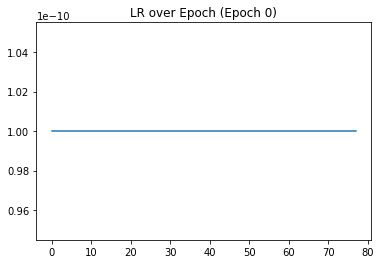

In [ ]:
#Plot the Learning rate
_ = plt.plot(lr[0])
_ = plt.title('LR over Epoch (Epoch 0)')

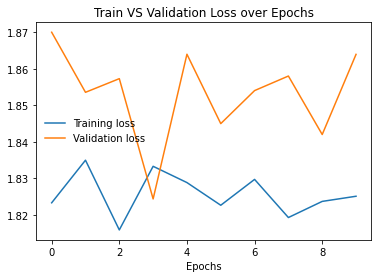

In [ ]:
#inspired from: https://nbviewer.jupyter.org/github/FraPochetti/KagglePlaygrounds/blob/master/NYC%20Taxi%20Fares%20Prediction.ipynb 
# Train VS Validaton Loss

t = [np.mean(tloss[el]) for el in tloss]
v = [np.mean(vloss[el]) for el in vloss]

plt.plot(t, label='Training loss')
plt.plot(v, label='Validation loss')
plt.title("Train VS Validation Loss over Epochs")
plt.xlabel("Epochs")
plt.legend(frameon=False)

# Test 

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2171 entries, 44 to 14990
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pickup_latitude    2171 non-null   float64
 1   pickup_longitude   2171 non-null   float64
 2   dropoff_latitude   2171 non-null   float64
 3   dropoff_longitude  2171 non-null   float64
 4   dist_km            2171 non-null   float64
dtypes: float64(5)
memory usage: 101.8 KB


## 13.0. Abhishek updated - test to be compatible with Chicago Taxi

In [ ]:
# divide to conts columns + make them a tensor + to.cuda()
df_test_conts = df_test[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'dist_km']]
test_conts = df_test_conts.astype(np.float32)
test_conts = torch.tensor(test_conts.values).cuda()

## 14.0. Abhishek updated - make predictions for continous targets

In [ ]:
# make prediction
with torch.no_grad():
    model.eval()
    output = model.forward(test_conts).cuda()

In [ ]:
output

tensor([2.5015, 3.1674, 2.4598,  ..., 3.2030, 2.6986, 3.3108], device='cuda:0')

In [ ]:
len(output)

2171

In [ ]:
type(output)

torch.Tensor

In [ ]:
# convert to numpy array
np_output = output.cpu().numpy()

In [ ]:
type(np_output)

numpy.ndarray

In [ ]:
np_output

array([2.5014565, 3.1673682, 2.4597642, ..., 3.2029736, 2.698631 ,
       3.3107834], dtype=float32)

In [ ]:
#  exp to the output data

np_output_exp = np.exp(np_output)

In [ ]:
np_output_exp

array([12.20025 , 23.74491 , 11.702051, ..., 24.605587, 14.859376,
       27.406588], dtype=float32)

In [ ]:
# CONVERT to pandas data frame 

df_output =  pd.DataFrame(np_output_exp)

In [ ]:
df_output

,0
0,12.200250
1,23.744909
2,11.702051
3,12.891317
4,12.891317
...,...
2166,14.134616
2167,8.799543
2168,24.605587
2169,14.859376


In [ ]:
type(df_output)

pandas.core.frame.DataFrame

In [ ]:
#output file

df_output.to_csv('submission.csv', index=False)


In [ ]:
# function that takes in a dataframe and creates a text link to  
# download it (will only work for files < 2MB or so)

from IPython.display import HTML
import base64

def create_download_link(df, title = "Download CSV file", filename = "submission.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

In [ ]:
# create a link to download the dataframe
create_download_link(df_output)